This file is used  to visualize the variant selection results of k562_bt142 data.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import vireoSNP
from utilities import *
import re
import os

## Read data

In [29]:
## read p-value data
folder_path = "/home/linxy29/data/maester/maester_paper/k562_bt142/variant_selection/fixed_effect/"
res_name = "trimmed_starsolo_chrM_cellSNP0"
output_folder = folder_path + res_name + "_analysis/"## get the p-value of the paper site
## if the output folder does not exist, create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
res = pd.read_csv(folder_path + res_name + "_res.csv", index_col=0)
print("The dimension of the p-value data is: ", res.shape)
print(res.head())

The dimension of the p-value data is:  (12666, 4)
        Wald_pval    LR_val  LRT_pval   LRT_fdr
681T>N   0.478269  0.496936  0.779995  1.000000
682A>C   0.108487  2.690036  0.260535  0.744724
683G>T   0.007620 -4.162745  1.000000  1.000000
684T>A   0.574830  0.294555  0.863054  1.000000
685A>C   0.070326 -0.848597  1.000000  1.000000


In [30]:
res['log_Wald_pval'] = np.log(res['Wald_pval'])
res['log_LRT_pval'] = np.log(res['LRT_pval'])
res['log_LRT_fdr'] = np.log(res['LRT_fdr'])
print("The dimension of the p-value data is: ", res.shape)
print(res.head())

The dimension of the p-value data is:  (12666, 7)
        Wald_pval    LR_val  LRT_pval   LRT_fdr  log_Wald_pval  log_LRT_pval  \
681T>N   0.478269  0.496936  0.779995  1.000000      -0.737581     -0.248468   
682A>C   0.108487  2.690036  0.260535  0.744724      -2.221122     -1.345018   
683G>T   0.007620 -4.162745  1.000000  1.000000      -4.877037      0.000000   
684T>A   0.574830  0.294555  0.863054  1.000000      -0.553681     -0.147278   
685A>C   0.070326 -0.848597  1.000000  1.000000      -2.654615      0.000000   

        log_LRT_fdr  
681T>N     0.000000  
682A>C    -0.294741  
683G>T     0.000000  
684T>A     0.000000  
685A>C     0.000000  


/home/linxy29/.conda/envs/maester/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/linxy29/.conda/envs/maester/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/linxy29/.conda/envs/maester/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [31]:
print(res[res['Wald_pval'] == 0].shape)
print(res[res['LRT_pval'] == 0].shape)
print(res[res['LRT_fdr'] == 0].shape)

(615, 7)
(51, 7)
(51, 7)


!We need to subset cells that are used for variants selection and use their infromation for further testing? - Yes

In [32]:
variant_folder = "/home/linxy29/data/maester/maester_paper/k562_bt142/maester/" + res_name + "/"
k562bt142_mquad, k562bt142_barcode = load_cellsnp(variant_folder)
k562bt142_mquad.variants = [f"{parts[1]}{parts[2]}>{parts[3]}" for parts in (variant.split('_') for variant in k562bt142_mquad.variants)] ## change the variant names to the format of the paper
print("The dimension of the AD data is: ", k562bt142_mquad.ad.shape)
print("The dimension of the DP data is: ", k562bt142_mquad.dp.shape)
print("The number of mtSNPs is: ", len(k562bt142_mquad.variants))

Loaded VCF file: /home/linxy29/data/maester/maester_paper/k562_bt142/maester/trimmed_starsolo_chrM_cellSNP0/cellSNP.cells.vcf.gz
16569 variants detected
variant names detected
The dimension of the AD data is:  (16569, 6196)
The dimension of the DP data is:  (16569, 6196)
The number of mtSNPs is:  16569


In [33]:
# Read paper variants
paper_variant_file = '/home/linxy29/data/maester/maester_paper/k562_bt142/variant_selection/paper_variant.txt'

# Read the paper variants into a set for efficient lookups
with open(paper_variant_file, 'r') as file:
    paper_variants = set(file.read().splitlines())

print("The first 10 paper variants are: ", list(paper_variants)[:10])
print("The number of paper variants is: ", len(paper_variants))

The first 10 paper variants are:  ['1420T>C', '7990C>T', '2141T>C', '709G>A', '1888G>A', '9117T>C']
The number of paper variants is:  6


In [34]:
# Read clone ID
clonID = pd.read_csv("/home/linxy29/data/maester/maester_paper/k562_bt142/cell_label.csv")
print("The dimension of the clone ID data is: ", clonID.shape)
print(clonID.head())

The dimension of the clone ID data is:  (2666, 2)
            barcode true_label
0  ATGAGGGCAATAGTCC       K562
1  AGTACTGGTCAACCAT       K562
2  CATCCACCAGTGTGCC       K562
3  TATACCTAGTCCCTAA       K562
4  TCCGATCGTGCAACGA       K562


## Plot
We can plot 1) p-values and allele frequencies of variants defined in the original paper; Plot 2) Description of p-values; Plot 3) variants with low p-values

Let's start with plot 1.

Check whether the mutation site are in the paper

In [35]:
paper_site = [int(re.match(r'\d+', item).group()) for item in paper_variants]
print("The first 10 mutation sites in paper are: ", paper_site[:10])
pval_site = [int(re.match(r'\d+', item).group()) for item in res.index]
print("The first 10 mutation sites in data are: ", pval_site[:10])
## get the index of the paper site in the data site
paper_pval_index = [pval_site.index(item) for item in paper_site]
print("The first 10 paper index are: ", paper_pval_index[:10])

The first 10 mutation sites in paper are:  [1420, 7990, 2141, 709, 1888, 9117]
The first 10 mutation sites in data are:  [681, 682, 683, 684, 685, 686, 687, 688, 689, 690]
The first 10 paper index are:  [735, 5825, 1355, 28, 1102, 6654]


In [36]:
print(paper_variants)

{'1420T>C', '7990C>T', '2141T>C', '709G>A', '1888G>A', '9117T>C'}


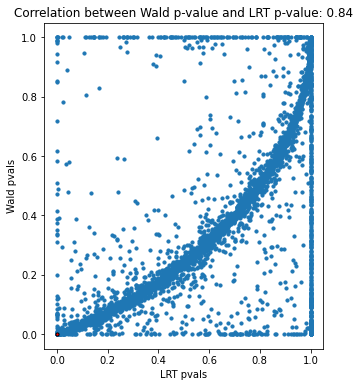

In [40]:
#candidate_res = res[(res['Wald_pval'] <= 0.05) & (res['LRT_pval'] <= 0.05)]
selected_rows = res[res.index.isin(paper_variants)]

plt.figure(figsize=(5, 6))
plt.scatter(x=res['LRT_pval'], y=res['Wald_pval'], s=10)
plt.scatter(selected_rows['LRT_pval'], selected_rows['Wald_pval'], s=10, label='Selected Variants', color='red', edgecolors='black')
plt.xlabel('LRT pvals')  
plt.ylabel('Wald pvals')  
correlation = res['LRT_pval'].corr(res['Wald_pval'])
plt.title(f'Correlation between Wald p-value and LRT p-value: {correlation:.2f}')
plt.savefig(output_folder + "pval_Wald_LRT.svg", format='svg')
plt.show()

Subset cells with cell line information from all cells (can be skipped).

In [10]:
## get indices in mquad data
mquad_site = [int(re.match(r'\d+', item).group()) for item in k562bt142_mquad.variants]
print("The first 10 data sites are: ", mquad_site[:10])
## get the index of the paper site in the mquad site
paper_mquad_index = [mquad_site.index(item) for item in paper_site]
print("The first 10 paper index are: ", paper_mquad_index[:10])
## get the cell index that have cell line information
include_cell_index = [index for index in range(len(k562bt142_barcode)) if k562bt142_barcode[index] in clonID['barcode'].values]
include_cell_barcode = [k562bt142_barcode[index] for index in include_cell_index]
print("The number of cell line cells are: ", len(include_cell_index))

The first 10 data sites are:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
The first 10 paper index are:  [1419, 7989, 2140, 708, 1887, 9116]
The number of cell line cells are:  2655


In [12]:
true_variants_mquad, true_variants_barcode = select_mquad(k562bt142_mquad, k562bt142_barcode, include_indices= paper_mquad_index, include_cell=include_cell_index)
print("The dimension of the AD data is: ", true_variants_mquad.ad.shape)
print("The dimension of the DP data is: ", true_variants_mquad.dp.shape)
print("The number of mtSNPs is: ", len(true_variants_mquad.variants))

The dimension of the AD data is:  (6, 2655)
The dimension of the DP data is:  (6, 2655)
The number of mtSNPs is:  6


Write mitochondrial file for clonal assignment (can be skipped).

In [13]:
write_mquad(true_variants_mquad, true_variants_barcode, "/home/linxy29/data/maester/maester_paper/k562_bt142/maester/trimmed_starsolo_chrM_cellSNP0_paperVariantCell")
subsetCell_mquad, subsetCell_barcode = select_mquad(k562bt142_mquad, k562bt142_barcode, include_cell=include_cell_index)
write_mquad(subsetCell_mquad, subsetCell_barcode, "/home/linxy29/data/maester/maester_paper/k562_bt142/maester/trimmed_starsolo_chrM_cellSNP0_paperCell")
print("The dimension of the AD data is: ", subsetCell_mquad.ad.shape)
print("The dimension of the DP data is: ", subsetCell_mquad.dp.shape)
print("The number of mtSNPs is: ", len(subsetCell_mquad.variants))

The dimension of the AD data is:  (16569, 2655)
The dimension of the DP data is:  (16569, 2655)
The number of mtSNPs is:  16569


In [14]:
clonID[clonID['barcode'].isin(include_cell_barcode)].to_csv("/home/linxy29/data/maester/maester_paper/k562_bt142/maester/trimmed_starsolo_chrM_cellSNP0_paperCell/cell_label.csv", index=False)
clonID[clonID['barcode'].isin(include_cell_barcode)].to_csv("/home/linxy29/data/maester/maester_paper/k562_bt142/maester/trimmed_starsolo_chrM_cellSNP0_paperVariantCell/cell_label.csv", index=False)

Plot the allele frequency of variants from paper

In [15]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

raw_col = cm.get_cmap('pink_r', 200)
new_colors = raw_col(np.linspace(0, 1, 256))
even_seg_pink = LinearSegmentedColormap.from_list("even_seg_pink", new_colors)
new_col = np.vstack((raw_col(np.linspace(0, 0.7, 10)),
                     raw_col(np.linspace(0.7, 1, 90))))
segpink = ListedColormap(new_col, name='segpink')

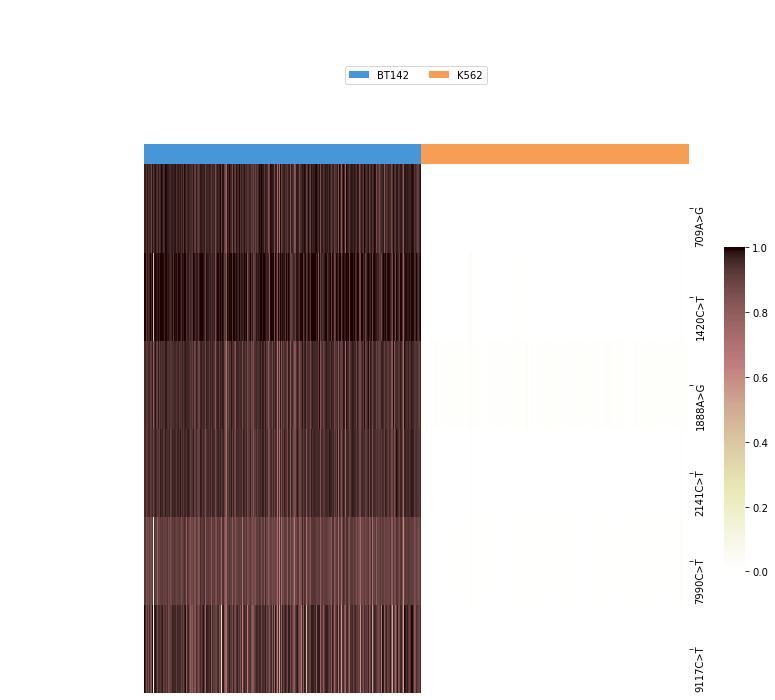

In [16]:
mtSNP_ids = true_variants_mquad.variants
cell_label = [clonID[clonID['barcode'] == barcode]['true_label'].values[0] for barcode in include_cell_barcode]
id_uniq = np.unique(cell_label)
vireoSNP.plot.anno_heat(true_variants_mquad.ad/true_variants_mquad.dp, col_anno=cell_label, col_order_ids=id_uniq,
                        cmap=even_seg_pink, yticklabels=mtSNP_ids)
plt.savefig(output_folder + "paperVariants_AF_heatmap.svg", format='svg')
plt.show()

Plot 2) Description of p-values (can be skipped).

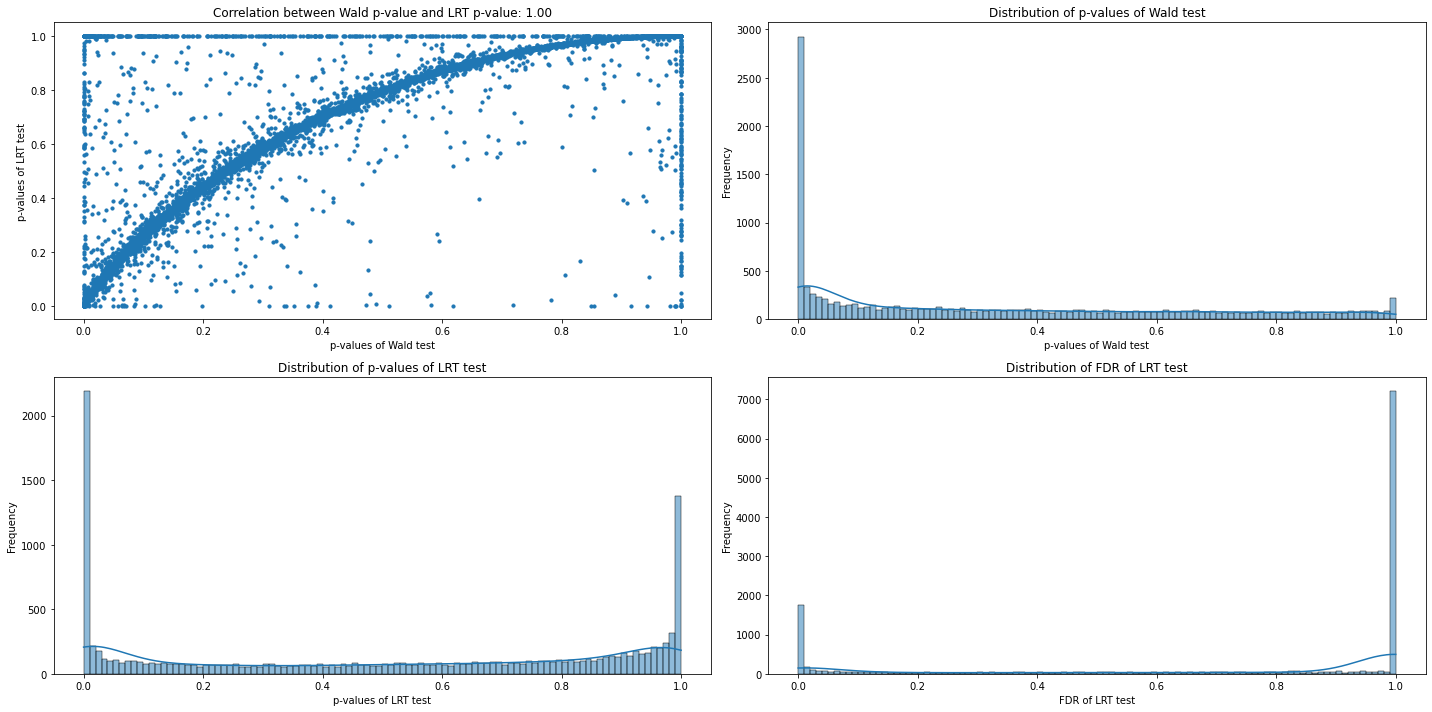

In [17]:
# Create a figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Plot the dot plot of the p-values in the first subplot
axes[0,0].scatter(res['Wald_pval'], res['LRT_pval'], s=10)  # Increased the size for better visibility
axes[0,0].set_xlabel('p-values of Wald test')
axes[0,0].set_ylabel('p-values of LRT test')
correlation = res['LRT_pval'].corr(res['LRT_pval'])
axes[0,0].set_title(f'Correlation between Wald p-value and LRT p-value: {correlation:.2f}')

# Plot the distribution of res['LRT_pval'] in the second subplot
sns.histplot(res['Wald_pval'], bins=100, kde=True, ax=axes[0,1])
axes[0,1].set_xlabel('p-values of Wald test')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of p-values of Wald test')

# Plot the distribution of res['LRT_pval'] in the third subplot
sns.histplot(res['LRT_pval'], bins=100, kde=True, ax=axes[1,0])
axes[1,0].set_xlabel('p-values of LRT test')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of p-values of LRT test')

# Plot the distribution of res['LR_fdr'] in the fourth subplot
sns.histplot(res['LRT_fdr'], bins=100, kde=True, ax=axes[1,1])
axes[1,1].set_xlabel('FDR of LRT test')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of FDR of LRT test')

# Show the plot
plt.tight_layout()

# Save the plot
plt.savefig(output_folder + "pval_distribution.svg", format='svg')
plt.show()

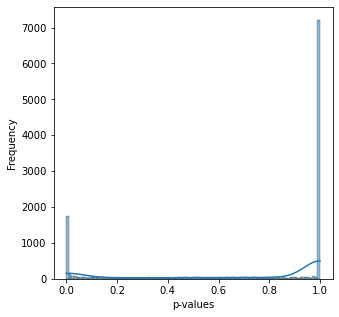

In [18]:
## plot one p-value plot for demonstration
plt.figure(figsize=(5, 5))
sns.histplot(res['LRT_fdr'], bins=100, kde=True)
plt.xlabel('p-values')
plt.ylabel('Frequency')

# Save the plot
plt.savefig(output_folder + "pval_demonstration.svg", format='svg')
plt.show()

Plot 3) variants with low p-values

In [11]:
## get the variants where LRTe p-value is less than 0.05
sig_LRT = res[res['LRT_pval'] < 0.05].index
print("The first 10 significant sites by LRT test are: ", sig_LRT[:10])
print("The number of significant sites by LRT test is: ", len(sig_LRT))

The first 10 significant sites by LRT test are:  Index(['686A>C', '689T>G', '703A>C', '708C>A', '709A>G', '711T>A', '714A>C',
       '720T>G', '733T>A', '735A>T'],
      dtype='object')
The number of significant sites by LRT test is:  2796


Save mitochondrial profile from selected variants (can be skipped).

In [16]:
sig_LRT_mquad_index = [k562bt142_mquad.variants.index(item) for item in sig_LRT]
sig_LRT_variants_mquad, sig_LRT_variants_barcode = select_mquad(k562bt142_mquad, k562bt142_barcode, include_indices= sig_LRT_mquad_index, include_cell=include_cell_index)
write_mquad(sig_LRT_variants_mquad, sig_LRT_variants_barcode, "/home/linxy29/data/maester/maester_paper/k562_bt142/maester/trimmed_starsolo_chrM_cellSNP0_LRTVariant_paperCell")
print("The dimension of the AD data is: ", sig_LRT_variants_mquad.ad.shape)
print("The dimension of the DP data is: ", sig_LRT_variants_mquad.dp.shape)
print("The number of mtSNPs is: ", len(sig_LRT_variants_mquad.variants))

The dimension of the AD data is:  (2796, 2655)
The dimension of the DP data is:  (2796, 2655)
The number of mtSNPs is:  2796


In [21]:
## select cloneID using include_cell_barcode
clonID[clonID['barcode'].isin(sig_LRT_variants_barcode)].to_csv("/home/linxy29/data/maester/maester_paper/k562_bt142/maester/trimmed_starsolo_chrM_cellSNP0_LRTVariant_paperCell/cell_label.csv", index=False)

In [12]:
## calculate the allel frequency
af = np.divide(k562bt142_mquad.ad, k562bt142_mquad.dp, where=k562bt142_mquad.dp!=0)
af[np.isnan(af)] = 0
## get the mean of af
mean_af = np.mean(af, axis=1)
variance_af = np.var(af, axis=1)

## get the standard deviation of af in two groups
k562_cell = clonID[clonID['true_label'] == 'K562']['barcode']
# Find indices of k562_cell barcodes in k562bt142_barcode
k562_indices = [np.where(k562bt142_barcode == barcode)[0][0] for barcode in k562_cell if barcode in k562bt142_barcode]
# Extract allele frequency data for K562 cell barcodes
k562_af = af[:, k562_indices]
print("The dimension of the K562 cell line is: ", k562_af.shape)
# Calculate the standard deviation of allele frequency in the K562 group
k562_af_std = np.std(k562_af, axis=1)
print("Standard deviation of allele frequency in the K562 group: ", k562_af_std)

# Find indices of bt142_cell barcodes in k562bt142_barcode
bt142_cell = clonID[clonID['true_label'] == 'BT142']['barcode']
bt142_indices = [np.where(k562bt142_barcode == barcode)[0][0] for barcode in bt142_cell if barcode in k562bt142_barcode]
# Extract allele frequency data for BT142 cell barcodes
bt142_af = af[:, bt142_indices]
# Calculate the standard deviation of allele frequency in the BT142 group
bt142_af_std = np.std(bt142_af, axis=1)

The dimension of the K562 cell line is:  (16569, 1306)
Standard deviation of allele frequency in the K562 group:  [0.         0.         0.02766063 ... 0.         0.         0.        ]


In [13]:
## create dataframe with variant name, mean af and variance af
af_df = pd.DataFrame({
    'variant': k562bt142_mquad.variants,  # list or array of variant names
    'mean_af': mean_af,                   # mean allele frequency array
    'variance_af': variance_af,           # variance of allele frequency array
    'k562_af_std': k562_af_std,           # K562 standard deviation array
    'bt142_af_std': bt142_af_std,         # BT142 standard deviation array
    'total_std': k562_af_std + bt142_af_std  # Total standard deviation
})

# Resetting the index of 'res' DataFrame and renaming the index column to 'variant'
res = res.reset_index().rename(columns={'index': 'variant'})
print("The first 10 rows of the af data are: \n", res.head(10))

The first 10 rows of the af data are: 
   variant  Wald_pval     LR_val  LRT_pval   LRT_fdr  log_Wald_pval  \
0  681T>N   0.478269   0.496936  0.779995  1.000000      -0.737581   
1  682A>C   0.108487   2.690036  0.260535  0.744724      -2.221122   
2  683G>T   0.007620  -4.162745  1.000000  1.000000      -4.877037   
3  684T>A   0.574830   0.294555  0.863054  1.000000      -0.553681   
4  685A>C   0.070326  -0.848597  1.000000  1.000000      -2.654615   
5  686A>C   0.000568  11.452419  0.003259  0.021379      -7.473894   
6  687G>T   0.013551   1.075361  0.584101  1.000000      -4.301317   
7  688A>T   0.816885   0.600690  0.740563  1.000000      -0.202257   
8  689T>G   0.002966   8.591541  0.013626  0.075630      -5.820374   
9  690T>A   0.212892  -4.338309  1.000000  1.000000      -1.546971   

   log_LRT_pval  log_LRT_fdr  
0     -0.248468     0.000000  
1     -1.345018    -0.294741  
2      0.000000     0.000000  
3     -0.147278     0.000000  
4      0.000000     0.000000  
5  

In [14]:
## merge the af data with the p-value data
af_df = pd.merge(res, af_df, on='variant')
print("The first 10 rows of the merged data are: \n", af_df.head(10))

The first 10 rows of the merged data are: 
   variant  Wald_pval     LR_val  LRT_pval   LRT_fdr  log_Wald_pval  \
0  681T>N   0.478269   0.496936  0.779995  1.000000      -0.737581   
1  682A>C   0.108487   2.690036  0.260535  0.744724      -2.221122   
2  683G>T   0.007620  -4.162745  1.000000  1.000000      -4.877037   
3  684T>A   0.574830   0.294555  0.863054  1.000000      -0.553681   
4  685A>C   0.070326  -0.848597  1.000000  1.000000      -2.654615   
5  686A>C   0.000568  11.452419  0.003259  0.021379      -7.473894   
6  687G>T   0.013551   1.075361  0.584101  1.000000      -4.301317   
7  688A>T   0.816885   0.600690  0.740563  1.000000      -0.202257   
8  689T>G   0.002966   8.591541  0.013626  0.075630      -5.820374   
9  690T>A   0.212892  -4.338309  1.000000  1.000000      -1.546971   

   log_LRT_pval  log_LRT_fdr   mean_af   variance_af  k562_af_std  \
0     -0.248468     0.000000  0.000012  4.481053e-08     0.000171   
1     -1.345018    -0.294741  0.000192  7.21752

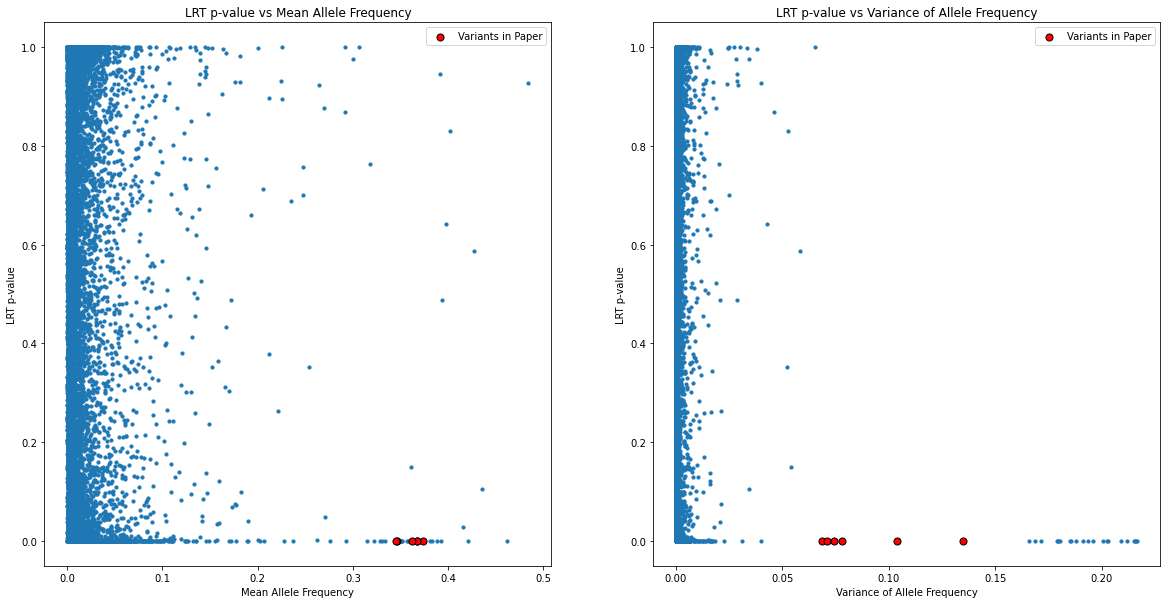

In [24]:
selected_variants = [
    '7990C>T', '1420C>T', '13966C>G', '4216C>A', '6524G>A', '11816G>A', '11764G>A',
    '11812G>A', '13965C>A', '8697A>G', '15607G>A', '15567G>A', '12151G>A', '9117G>T',
    '6249A>G', '15243A>G', '13368A>G', '14905A>G', '709A>G', '1888A>G', '2141C>T',
    '4215A>T', '13063G>C', '14904T>C', '8693A>C', '13350A>G', '13314C>A', '11289T>G',
    '13425C>A', '1885A>G', '15521G>C', '2147G>A', '8698A>G', '11697T>C', '1891T>A',
    '8699T>A', '11718G>C', '15519T>A', '1889C>G', '6935C>G', '8213G>A'
]
selected_variants = [
    '7990C>T', '1420C>T', '13966C>G', '4216C>A', '6524G>A', '11816G>A', '11764G>A',
    '11812G>A', '13965C>A', '8697A>G', '15607G>A', '15567G>A', '12151G>A', '9117G>T',
    '6249A>G', '15243A>G', '13368A>G', '14905A>G', '709A>G', '1888A>G', '2141C>T'
]
selected_rows = af_df[af_df['variant'].isin(selected_variants)]
paperVariant_rows = af_df[af_df['variant'].isin(true_variants_mquad.variants)]
# Plot LRT p-value vs mean af and LRT p-value vs variance af
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot all rows
axes[0].scatter(af_df['mean_af'], af_df['LRT_pval'], s=10)
# Highlight selected rows
#axes[0].scatter(selected_rows['mean_af'], selected_rows['LRT_pval'], s=50, label='Selected Variants', color='red', edgecolors='black')
axes[0].scatter(paperVariant_rows['mean_af'], paperVariant_rows['LRT_pval'], s=50, label='Variants in Paper', color='red', edgecolors='black')

axes[0].set_xlabel('Mean Allele Frequency')
axes[0].set_ylabel('LRT p-value')
axes[0].set_title('LRT p-value vs Mean Allele Frequency')
axes[0].legend()

# Plot all rows
axes[1].scatter(af_df['variance_af'], af_df['LRT_pval'], s=10)
# Highlight selected rows
#axes[1].scatter(selected_rows['variance_af'], selected_rows['LRT_pval'], s=50, label='Selected Variants', color='red', edgecolors='black')
axes[1].scatter(paperVariant_rows['total_std'], paperVariant_rows['LRT_pval'], s=50, label='Variants in Paper', color='red', edgecolors='black')

axes[1].set_xlabel('Variance of Allele Frequency')
axes[1].set_ylabel('LRT p-value')
axes[1].set_title('LRT p-value vs Variance of Allele Frequency')
axes[1].legend()

# Save the plot
plt.savefig(output_folder + "LRT_pval_vs_af_mean_variance_labeledPaper.svg", format='svg')
plt.show()

In [17]:
## order af_df by the ascending order of LRT p-value and descending order of LRT p-value
af_df = af_df.sort_values(by=['LRT_pval', 'variance_af'], ascending=[True, False])
## select first 30 variants
top30_variants_LRT = af_df['variant'][:30].values
print(af_df.head(30))
print("The top30 variants by LRT test are: ", top30_variants_LRT)

        variant  Wald_pval       LR_val  LRT_pval  LRT_fdr  log_Wald_pval  \
10906  13965C>T        0.0  3788.217396       0.0      0.0           -inf   
735     1420C>T        0.0  5435.435911       0.0      0.0           -inf   
10907  13966G>A        0.0  4042.762887       0.0      0.0           -inf   
12374  15607G>A        0.0  8161.833908       0.0      0.0           -inf   
28       709A>G        0.0  7388.948921       0.0      0.0           -inf   
9696   12741T>C        0.0  3380.239723       0.0      0.0           -inf   
3234    4216C>T        0.0  6063.315657       0.0      0.0           -inf   
1355    2141C>T        0.0  8316.530659       0.0      0.0           -inf   
1102    1888A>G        0.0  8528.275374       0.0      0.0           -inf   
4272    6249A>G        0.0  7899.772025       0.0      0.0           -inf   
6654    9117C>T        0.0  5830.334159       0.0      0.0           -inf   
4547    6524C>T        0.0  7919.303558       0.0      0.0           -inf   

### Check variants with low p-values and high variance

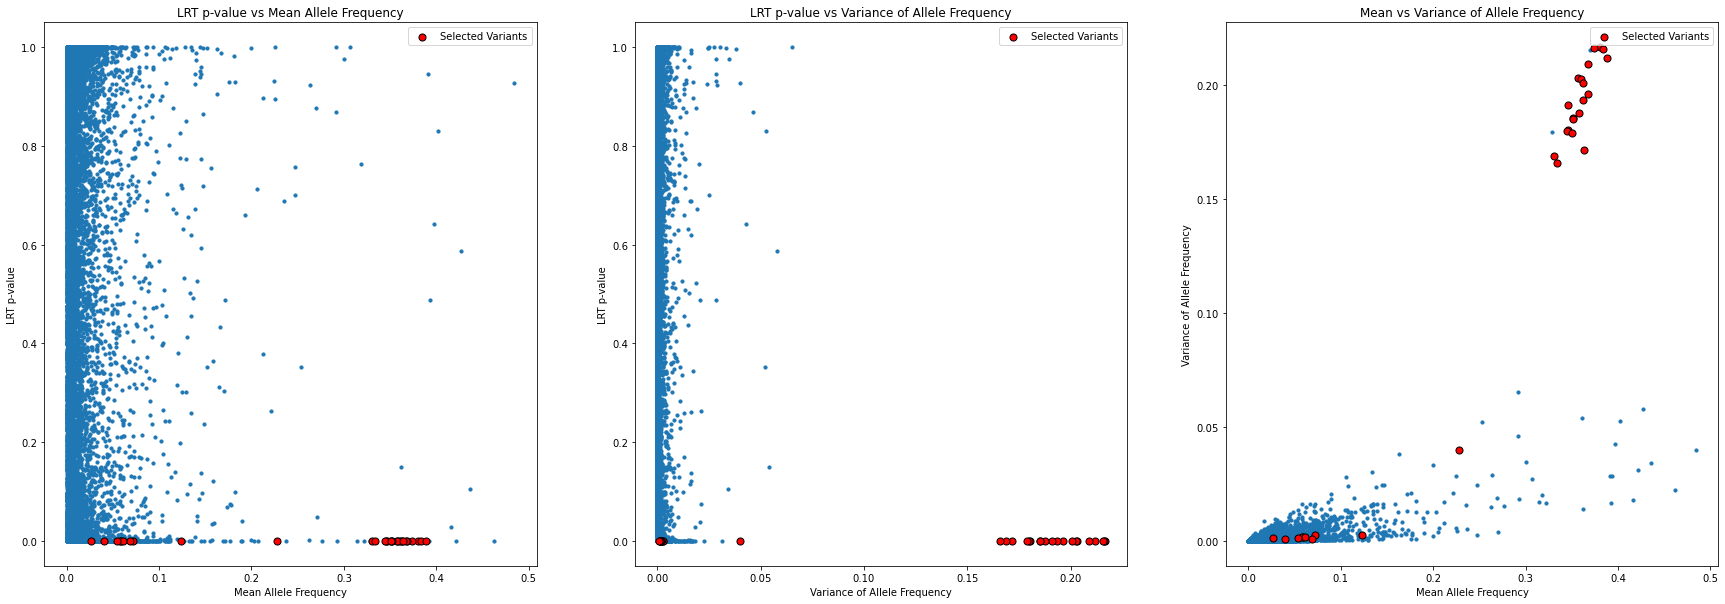

In [19]:
selected_rows = af_df[af_df['variant'].isin(top30_variants_LRT)]
# Plot LRT p-value vs mean af and LRT p-value vs variance af
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

# Plot all rows
axes[0].scatter(af_df['mean_af'], af_df['LRT_pval'], s=10)
# Highlight selected rows
axes[0].scatter(selected_rows['mean_af'], selected_rows['LRT_pval'], s=50, label='Selected Variants', color='red', edgecolors='black')

axes[0].set_xlabel('Mean Allele Frequency')
axes[0].set_ylabel('LRT p-value')
axes[0].set_title('LRT p-value vs Mean Allele Frequency')
axes[0].legend()

# Plot all rows
axes[1].scatter(af_df['variance_af'], af_df['LRT_pval'], s=10)
# Highlight selected rows
axes[1].scatter(selected_rows['variance_af'], selected_rows['LRT_pval'], s=50, label='Selected Variants', color='red', edgecolors='black')

axes[1].set_xlabel('Variance of Allele Frequency')
axes[1].set_ylabel('LRT p-value')
axes[1].set_title('LRT p-value vs Variance of Allele Frequency')
axes[1].legend()

# Plot all rows
axes[2].scatter(af_df['mean_af'], af_df['variance_af'], s=10)
# Highlight selected rows
axes[2].scatter(selected_rows['mean_af'], selected_rows['variance_af'], s=50, label='Selected Variants', color='red', edgecolors='black')

axes[2].set_xlabel('Mean Allele Frequency')
axes[2].set_ylabel('Variance of Allele Frequency')
axes[2].set_title('Mean vs Variance of Allele Frequency')
axes[2].legend()

# Save the plot
plt.savefig(output_folder + "sig_highVariance_LRT_pval_vs_af_mean_variance.svg", format='svg')
plt.show()

In [20]:
## get the index of the paper site in the mquad site
mquad_index = [k562bt142_mquad.variants.index(variant) for variant in top30_variants_LRT]
print("The number of random significant sites by LRT test is: ", len(top30_variants_LRT))
## select cells and variants
subset_mquad, subset_barcode = select_mquad(k562bt142_mquad, k562bt142_barcode, include_indices= mquad_index, include_cell=include_cell_index)
print("The dimension of the AD data is: ", subset_mquad.ad.shape)
print("The dimension of the DP data is: ", subset_mquad.dp.shape)
print("The number of mtSNPs is: ", len(subset_mquad.variants))

The number of random significant sites by LRT test is:  30
The dimension of the AD data is:  (30, 2655)
The dimension of the DP data is:  (30, 2655)
The number of mtSNPs is:  30


In [22]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

raw_col = cm.get_cmap('pink_r', 200)
new_col = np.vstack((raw_col(np.linspace(0, 0.7, 10)),
                     raw_col(np.linspace(0.7, 1, 90))))
segpink = ListedColormap(new_col, name='segpink')

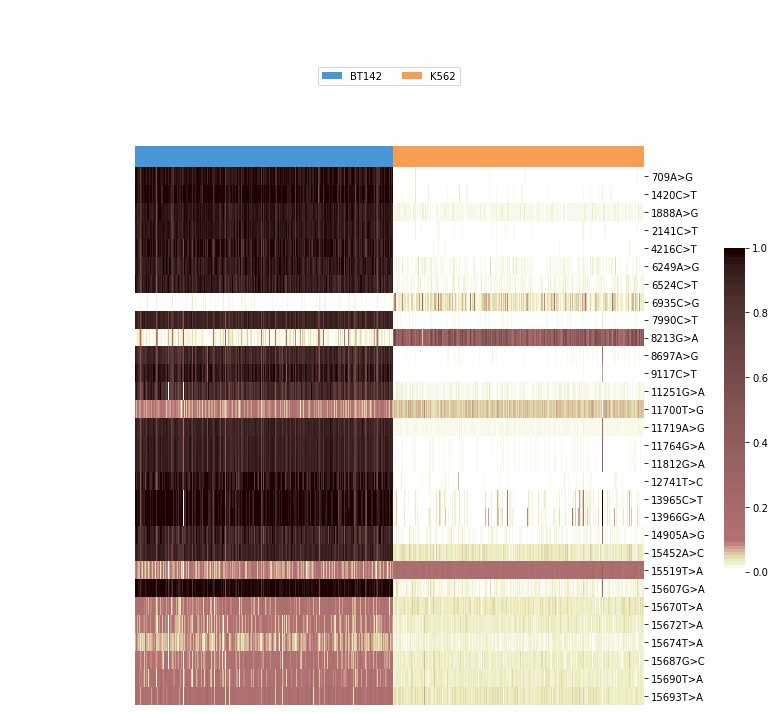

In [23]:
data_array = np.divide(subset_mquad.ad, subset_mquad.dp, where=(subset_mquad.dp != 0))
data_array = np.nan_to_num(data_array)
## plot
mtSNP_ids = subset_mquad.variants
cell_label = [clonID[clonID['barcode'] == barcode]['true_label'].values[0] for barcode in include_cell_barcode]
id_uniq = np.unique(cell_label)
vireoSNP.plot.anno_heat(data_array, col_anno=cell_label, col_order_ids=id_uniq,
                        cmap=segpink, yticklabels=mtSNP_ids)

plt.savefig(output_folder + "top30_LRT_AF_heatmap.svg", format='svg')
plt.show()